In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad
import scanpy as sc

from cellink import Cellink

/Users/luosanj/opt/anaconda3/envs/alignment/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# read in rna data
rna = pd.read_csv('/Users/luosanj/Desktop/project2/data/HPAP_rna_mat/HPAP-024_exp_mat.csv')
rna_feature = rna.iloc[:,0]
rna_obs = rna.columns[1:]
rna_mat = rna.iloc[:, 1:].to_numpy().T
# convert to anndata
rna_adata = ad.AnnData(rna_mat, dtype = np.float32)
rna_adata.var_names = rna_feature
rna_adata.obs_names = rna_obs

# read in cell type labels of scRNA
rna_ct = pd.read_csv('/Users/luosanj/Desktop/project2/data/HPAP_cell_annotations/HPAP-024_cell_annotations.csv')
label_rna = rna_ct['Celltype'].to_numpy()
rna_adata.obs['cell_type'] = label_rna

In [20]:
# read in protein data
protein_adata = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/HPAP024-AAB-18y-M-H_1_2_2-OCT/HPAP024-AAB-18y-M-H_1_2_2-OCT.h5ad')
protein_adata = protein_adata[protein_adata.obs['cell_type'] != 'Unidentified'].copy()
protein_adata_filter = protein_adata[
    (protein_adata.obsm['spatial'][:,0] > 5000) & (protein_adata.obsm['spatial'][:,0] < 14900) &
    (protein_adata.obsm['spatial'][:,1] > 29500) & (protein_adata.obsm['spatial'][:,1] < 35000)
]
protein_adata_filter.obs['cell_type'].value_counts()



cell_type
Duct Cell                         8875
Macrophage Cell                   2681
Vascular Endothelial Cell         2350
Beta Cell                         2258
Pericyte or Smooth Muscle Cell    2085
Lymphatic Endothelial Cell         935
Alpha Cell                         683
Exocrine Cell                      535
Mast Cell                          430
T Cell                             250
Gamma Cell                          86
Delta Cell                          10
Name: count, dtype: int64

In [21]:
def map_cell_types(cell_type):
    if cell_type in ['Lymphatic Endothelial Cell', 'Vascular Endothelial Cell']:
        return 'Endothelial'
    elif cell_type in ['T Cell', 'Macrophage Cell', 'Monocyte or Dendritic Cell']:
        return 'Immune'
    elif cell_type in ['Gamma Cell', 'Delta Cell']:
        return 'Delta-PP'
    elif cell_type == 'Exxocrine Cell':
        return 'Exocrine'
    elif cell_type == 'Exocrine Cell':
        return 'Exocrine'
    elif cell_type == 'Duct Cell':
        return 'Ductal'
    elif cell_type == 'Alpha Cell':
        return 'Alpha'
    elif cell_type == 'Acinar':
        return 'Exocrine'
    elif cell_type == 'Beta Cell':
        return 'Beta'
    else:
        return cell_type  # Return the original name if it doesn't match the above

# Apply the mapping function to each cell type in the 'cell_type' column
rna_adata.obs['cell_type'] = rna_adata.obs['cell_type'].apply(map_cell_types)
protein_adata_filter.obs['cell_type'] = protein_adata_filter.obs['cell_type'].apply(map_cell_types)

In [22]:
# # process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
#sc.pp.scale(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# # only retain highly variable genes
rna_adata1 = rna_adata[:, rna_adata.var.highly_variable].copy()
# # plot UMAPs of rna cells based on all active rna markers

# sc.pp.neighbors(rna_adata1, n_neighbors=15)
# sc.tl.umap(rna_adata1)
# sc.pl.umap(rna_adata1, color='cell_type')

In [23]:
correspondence = pd.read_csv('/Users/luosanj/Desktop/project2/data/protein_gene_relationship.csv')
rna_protein_correspondence = []

for i in range(correspondence.shape[0]):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata1.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])
            
rna_protein_correspondence = np.array(rna_protein_correspondence)

In [37]:
# correspondence information
protein_adata_filter.var_names_make_unique()
rna_shared = rna_adata1[:, rna_protein_correspondence[:, 0]].copy()
print(rna_shared.shape)
protein_shared = protein_adata_filter[:, rna_protein_correspondence[:, 1]].copy()
print(protein_shared.shape)
# extract 4 cell types to perform integration due to too unbalanced cell count
extract_ct = ['Alpha', 'Exocrine', 'Beta', 'Ductal']
rna_shared = rna_shared[rna_shared.obs['cell_type'].isin(extract_ct)]
protein_shared = protein_shared[protein_shared.obs['cell_type'].isin(extract_ct)]
#
# rna_adata1 = rna_adata1[rna_adata1.obs['cell_type'].isin(extract_ct)]
combined_adata = rna_adata[rna_adata.obs['cell_type'].isin(extract_ct)]
protein_adata_filter = protein_adata_filter[protein_adata_filter.obs['cell_type'].isin(extract_ct)]

(1266, 23)
(12351, 23)


In [38]:
# Make sure no column is static
mask = (
    (rna_shared.X.toarray().std(axis=0) > 0.01) 
    & (protein_shared.X.std(axis=0) > 0.01)
)
rna_shared = rna_shared[:, mask].copy()
protein_shared = protein_shared[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(1203, 19), (12351, 19)]


In [39]:
arr = [rna_shared, protein_shared]
cellink = Cellink(full_ann1 = combined_adata, full_ann2 = protein_adata_filter, shared_ann1 = rna_shared, shared_ann2 = protein_shared)
cellink.split_into_batches(arr, 1200, seed = 100)

Cell annotations are provided. Perform Iteratively OT!
The first modality is split into 1 batches, and max batch size is 1203.
The second modality is split into 10 batches, and max batch size is 1236.
Batch to batch correspondence is:
  ['0<->0', '0<->1', '0<->2', '0<->3', '0<->4', '0<->5', '0<->6', '0<->7', '0<->8', '0<->9'].


In [40]:
cellink.alignment(wt1 = 0.3, wt2 = 0.3, lambd = 0.002, reg = 0.002,
                  reg_m1 = (40, 0.01), reg_m2 = (0.01, 40), iterative = True, sparse = False)

Now at batch 0<->0...
870 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 4 iterations with cell-type matching accuracy 96.34%! 

There are 44 unmatched samples and 1159 matched samples in data1!
854 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 4 iterations with cell-type matching accuracy 97.57000000000001%! 

There are 30 unmatched samples and 1205 matched samples in data2!
Now at batch 0<->1...
869 cells from Modality X are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 4 iterations with cell-type matching accuracy 96.00999999999999%! 

There are 48 unmatched samples and 1155 matched samples in data1!
848 cells from Modality Y are unmatched in Phase I and are realigned in Phase II.
iterative unbalanced optimal transport converges after 3 iterations with 

In [ ]:
rna_source_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
rna_predict_ct_array = np.zeros(shape = rna_shared.shape[0], dtype = 'object')
# the cell index of the rna_aligned_protein is not the same as the original cell index, modify the logic by looping cellink.partition1[i] rather than len(rna_batch)
rna_aligned_protein = np.zeros(shape = (combined_adata.shape[0], protein_adata_filter.shape[1]))
for i in range(len(cellink.partition1)):
    cell_id = cellink.partition1[i]
    match_id = np.array(list(cellink.cell_correspondence_partition1[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        rna_source_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_rna = cellink.arr1_unmatched_cell_id[i]
        if j in unmatched_cell_id_rna:
            rna_predict_ct_array[cell_id[j]] = cellink.arr1_wrong_ct[i][np.where(unmatched_cell_id_rna == j)[0][0]]
            jump_num = jump_num + 1
        else:
            rna_predict_ct_array[cell_id[j]] = rna_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            rna_aligned_protein[cell_id[j], :] =  cellink.feature_imputation_partition1[i][nid, :]
            
protein_source_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_predict_ct_array = np.zeros(shape = protein_shared.shape[0], dtype = 'object')
protein_aligned_rna = np.zeros(shape = (protein_adata_filter.shape[0], combined_adata.shape[1]))
#protein_aligned_rna_full =  np.zeros(shape = (protein_adata.shape[0], rna_adata_all.shape[1]))
for i in range(len(cellink.partition2)):
    cell_id = cellink.partition2[i]
    cell_id_rna = cellink.partition1[0]
    match_id = np.array(list(cellink.cell_correspondence_partition2[i].keys()))
    jump_num = 0
    for j in range(len(cell_id)):
        protein_source_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
        unmatched_cell_id_protein = cellink.arr2_unmatched_cell_id[i]
        if j in unmatched_cell_id_protein:
            protein_predict_ct_array[cell_id[j]] = cellink.arr2_wrong_ct[i][np.where(unmatched_cell_id_protein == j)[0][0]]
            jump_num += 1
        else:
            protein_predict_ct_array[cell_id[j]] = protein_shared.obs['cell_type'].iloc[cell_id[j]]
            nid = np.where(match_id == j)[0][0]
            protein_aligned_rna[cell_id[j], :] =  cellink.feature_imputation_partition2[i][nid, :]

In [44]:
non_zero_rows = protein_source_ct_array == protein_predict_ct_array

d024_codex_imputed_rnaseq = ad.AnnData(X = protein_aligned_rna[non_zero_rows, :],
                                       obs = protein_adata_filter.obs.iloc[non_zero_rows],
                                       var = pd.DataFrame(combined_adata.var_names),
                                       )
for key in protein_adata_filter.obsm.keys():
    d024_codex_imputed_rnaseq.obsm[key] = protein_adata_filter.obsm[key][non_zero_rows, :]
d024_codex_imputed_rnaseq.var_names = d024_codex_imputed_rnaseq.var['Unnamed: 0']

In [3]:
d024_codex_imputed_rnaseq = sc.read_h5ad('/Users/luosanj/Desktop/project2/data/HPAP024_imputedRNA_newversion.h5ad')

In [5]:
# Assuming gene names are stored in adata.var_names
coding_genes_mask = ~d024_codex_imputed_rnaseq.var_names.str.startswith('ENSG')
d024_codex_imputed_rnaseq = d024_codex_imputed_rnaseq[:, coding_genes_mask]


In [11]:
# d024_codex_imputed_rnaseq.write_h5ad('/Users/luosanj/Desktop/project2/data/HPAP024_imputedRNA_newversion.h5ad')

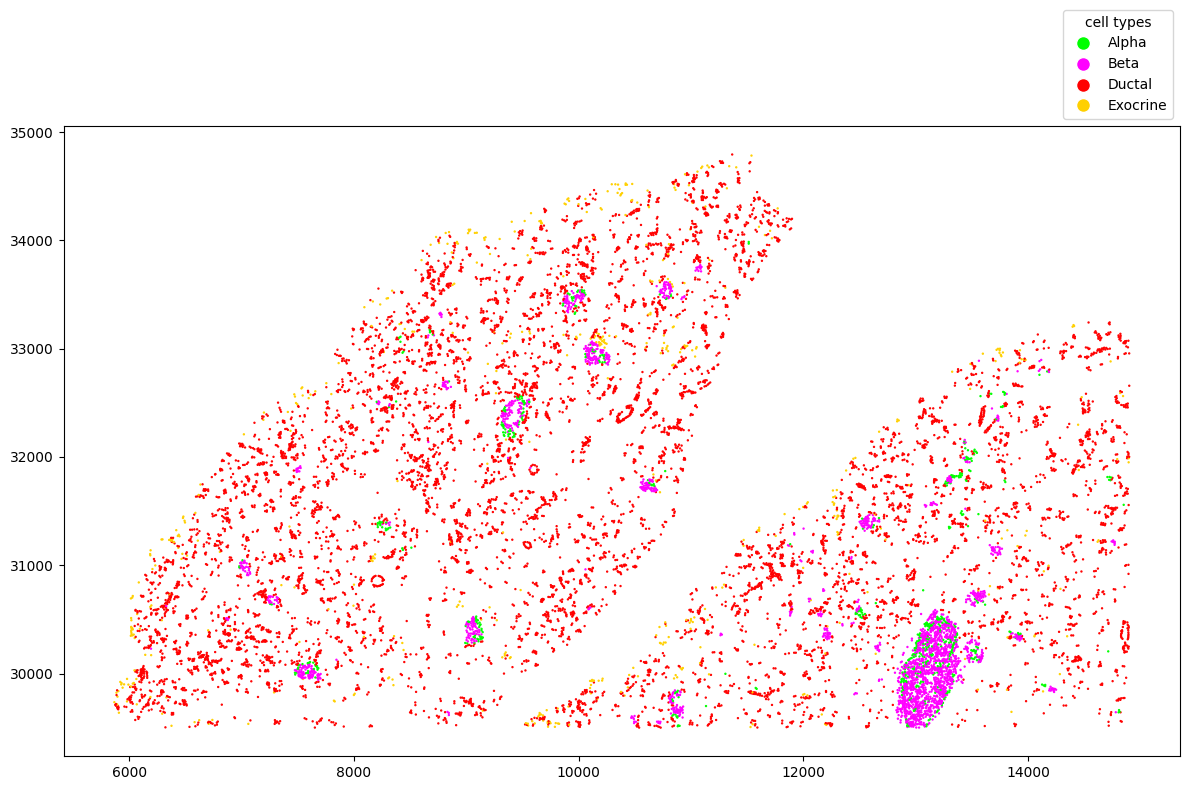

In [22]:
plt.figure(figsize=(12, 8))

def hex_to_normalized_rgba(hex, alpha=1.0):
    hex = hex.lstrip('#')
    h_len = len(hex)
    return tuple(int(hex[i:i + h_len // 3], 16) / 255.0 for i in range(0, h_len, h_len // 3)) + (alpha,)

# Define colors in hex
colorbar = {
    'Alpha': '#00FF00',   # Green
    'Beta': '#FF00FF',    # Magenta
    'Ductal': '#FF0000',  # Red
    'Exocrine': '#FFD000' # Yellow
}

# Convert hex to RGBA normalized for matplotlib
rgba_colors = {key: hex_to_normalized_rgba(value) for key, value in colorbar.items()}
colorbar = rgba_colors

color_points = [colorbar[i] for i in d024_codex_imputed_rnaseq.obs['cell_type']]

spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']
plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], color = color_points, s= 0.5)
legend_celltype = [Line2D([0], [0], marker='o', color='w', label=f'{t}',
                              markerfacecolor=c, markersize=10) for t, c in colorbar.items()]
plt.legend(handles = legend_celltype, title = "cell types", loc = "lower right", bbox_to_anchor=(1, 1))
plt.tight_layout()
#plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_ct.pdf', transparent=True, format = 'pdf')
plt.show()




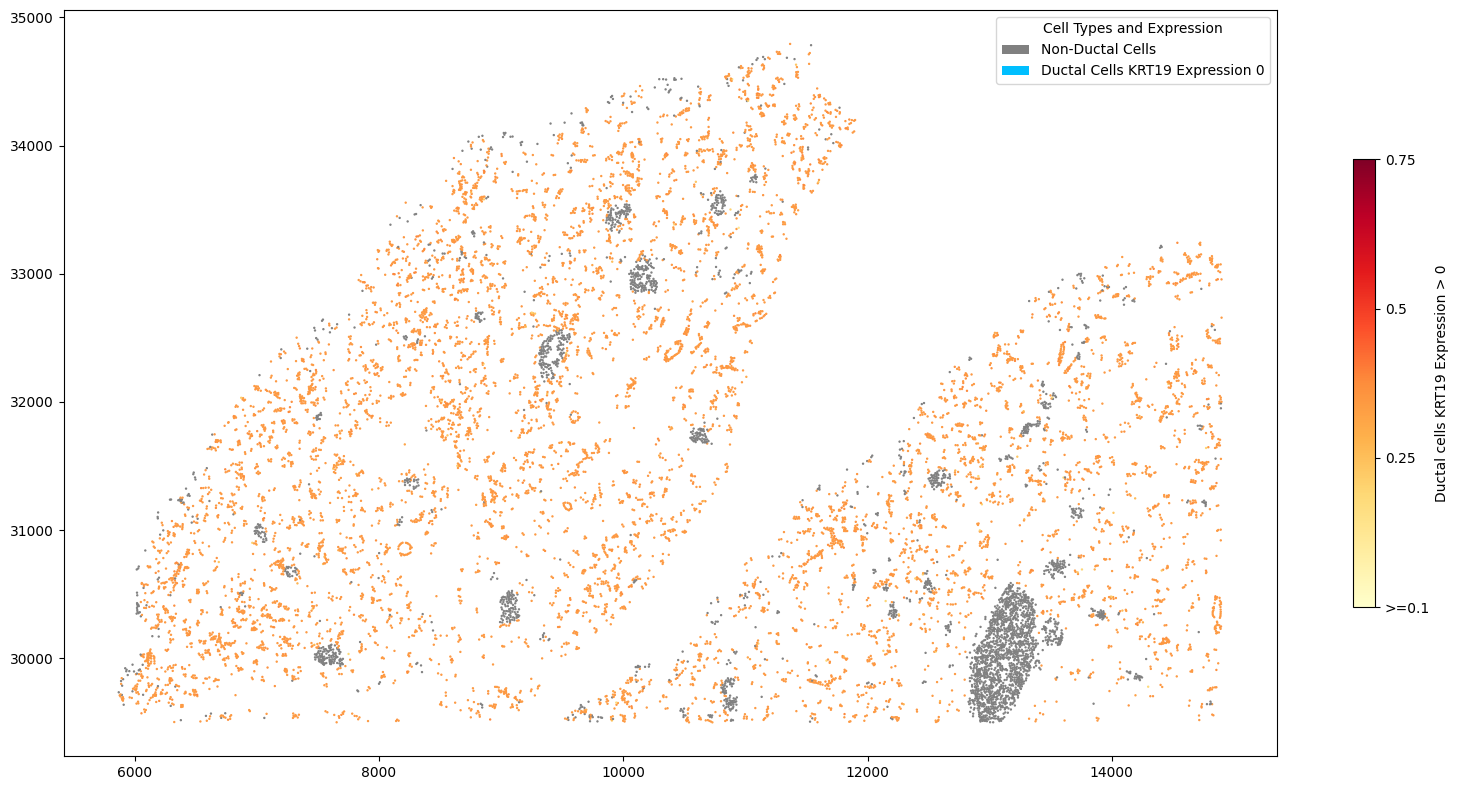

In [62]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Patch
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']
def get_color(cell_type, expression):
    if cell_type != 'Ductal':
        return 'grey'
    else:
        return 'deepskyblue' if expression < 0.01 else plt.cm.YlOrRd(expression)
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'KRT19'].X.toarray().flatten()
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(0, max(exps))
cmap = plt.cm.YlOrRd
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(exps[exps>0])  # Setting the array for ScalarMappable
cbar = plt.colorbar(sm, ax = ax, label='Ductal cells KRT19 Expression > 0', shrink=0.6)
cbar.set_ticks([0, max(exps) / 3, 2 * max(exps) / 3,  max(exps)])
cbar.set_ticklabels(['>=0.1', '0.25', '0.5', '0.75'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Ductal Cells'),
    Patch(facecolor='deepskyblue', label='Ductal Cells KRT19 Expression 0')]
ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.show()

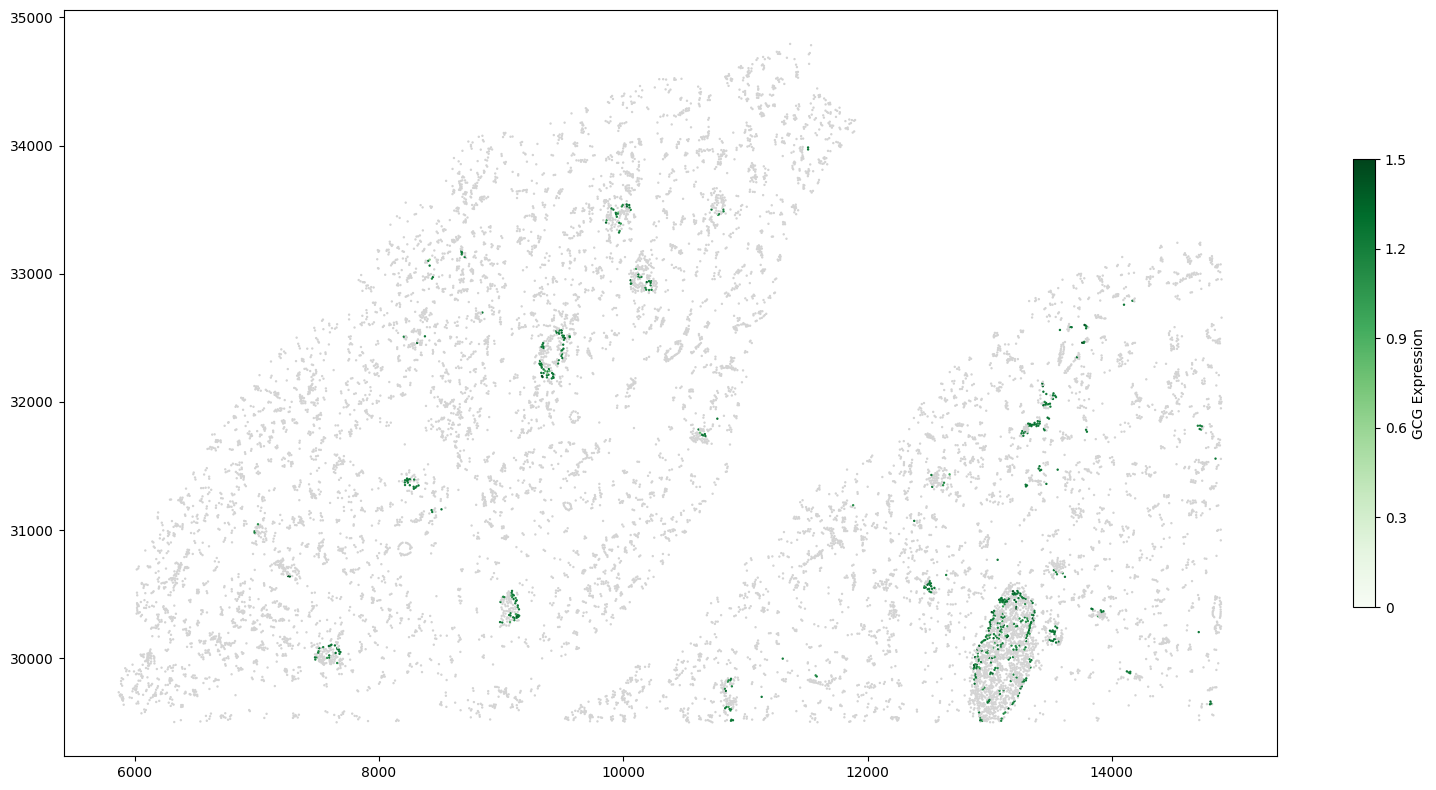

In [31]:
def get_color(cell_type, expression):
    if cell_type != 'Alpha':
        return 'lightgrey'
    else:
        return plt.cm.Greens(Normalize(0, max(exps))(expression))
    
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'GCG'].X.toarray().flatten()
#exps_above = exps[exps > 0.1]
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(min(exps), max(exps))
cmap = plt.cm.Greens  # Changed to a green colormap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(exps)
cbar = plt.colorbar(sm, ax = ax, label='GCG Expression', shrink=0.6)
cbar.set_ticks([0, max(exps) / 5, 2 * max(exps) / 5,  3 * max(exps) / 5, 4 * max(exps) / 5, max(exps)])
cbar.set_ticklabels(['0', '0.3', '0.6', '0.9', '1.2', '1.5'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Alpha Cells')]
#ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_alpha.pdf', transparent=True, format = 'pdf')
plt.show()

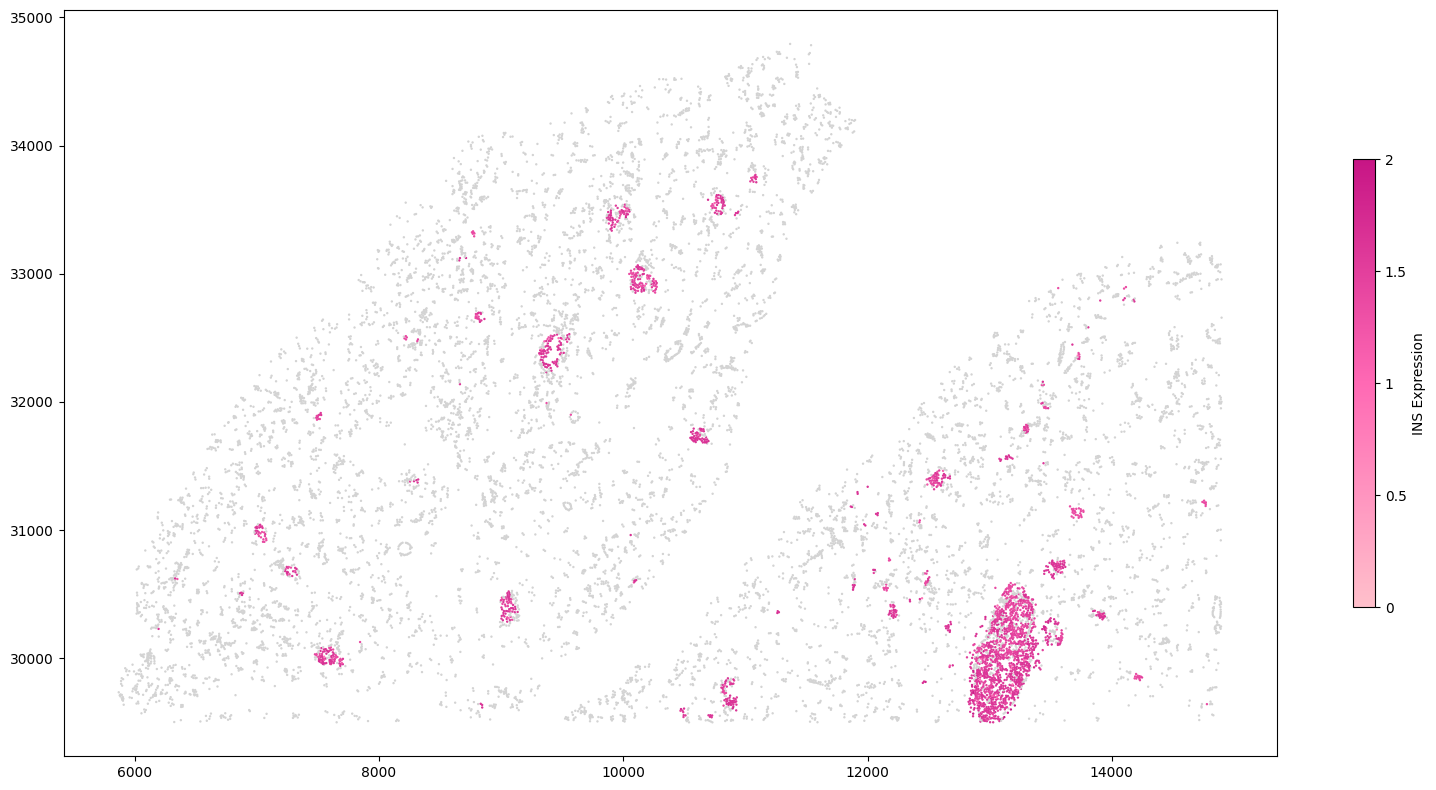

In [32]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']
pink_cmap = LinearSegmentedColormap.from_list("custom_pink", ["#FFC0CB", "#FF69B4", "#C71585"])
def get_color(cell_type, expression):
    if cell_type != 'Beta':
        return 'lightgrey'
    else:
        return pink_cmap(Normalize(0, max(exps))(expression))
    
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'INS'].X.toarray().flatten()
#exps_above = exps[exps > 0.1]
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(min(exps), max(exps))
sm = plt.cm.ScalarMappable(cmap=pink_cmap, norm=norm)
sm.set_array(exps[exps>0])  # Setting the array for ScalarMappable
cbar = plt.colorbar(sm, ax = ax, label='INS Expression', shrink=0.6)
cbar.set_ticks([0, max(exps) / 4, 2 * max(exps) / 4,  3 * max(exps) / 4, 4 * max(exps) / 4])
cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Beta Cells')]
#ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_beta.pdf', transparent=True, format = 'pdf')
plt.show()

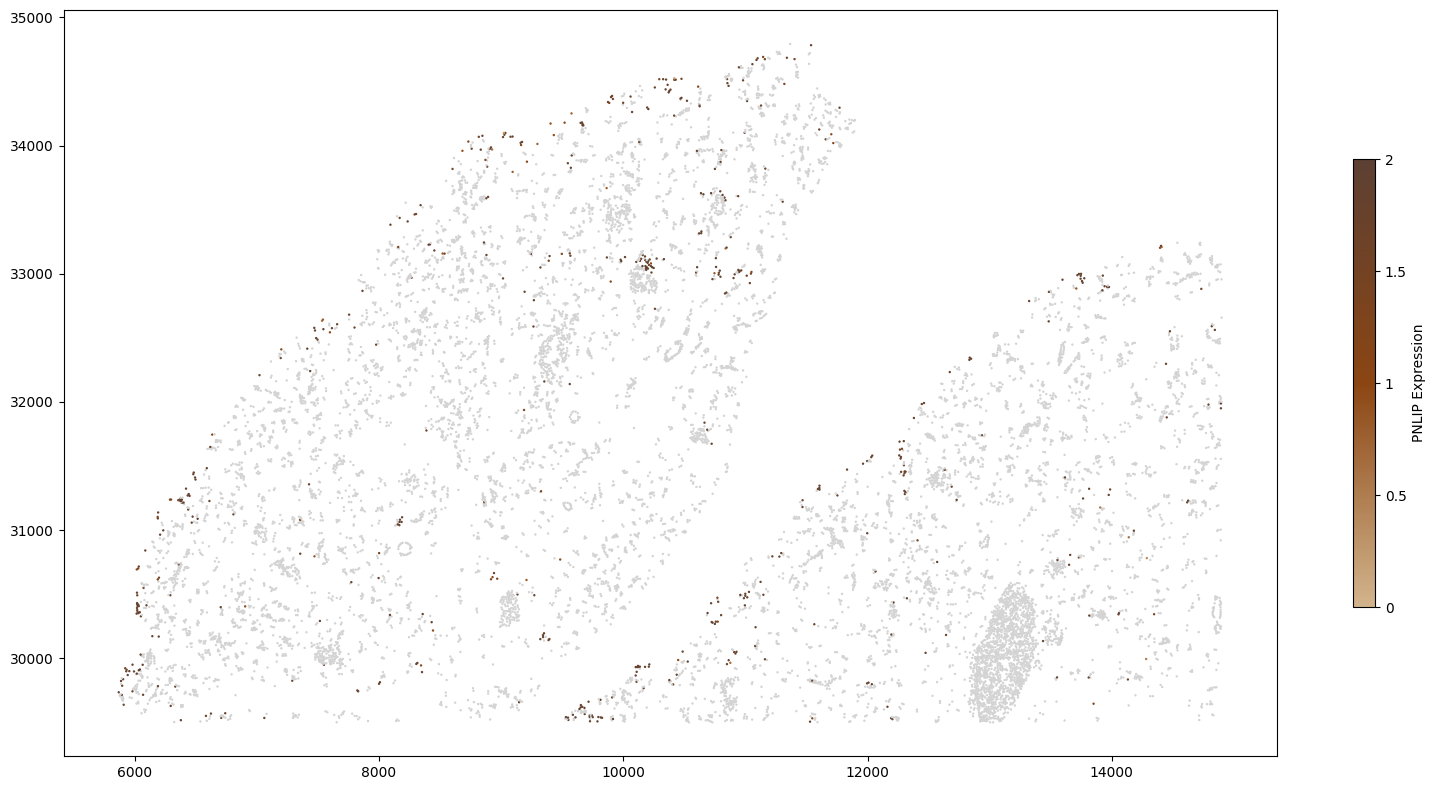

In [34]:
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']
brown_cmap = LinearSegmentedColormap.from_list("custom_brown", ["#D2B48C", "#8B4513", "#5C4033"]) 
def get_color(cell_type, expression):
    if cell_type != 'Exocrine':
        return 'lightgrey'
    else:
        return brown_cmap(Normalize(0, max(exps))(expression))
    
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'PNLIP'].X.toarray().flatten()
#exps_above = exps[exps > 0.1]
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(min(exps), max(exps))
sm = plt.cm.ScalarMappable(cmap=brown_cmap, norm=norm)
sm.set_array(exps[exps>0])  # Setting the array for ScalarMappable
cbar = plt.colorbar(sm, ax = ax, label='PNLIP Expression', shrink=0.6)
cbar.set_ticks([0, max(exps) / 4, 2 * max(exps) / 4,  3 * max(exps) / 4, 4 * max(exps) / 4])
cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Exocrine Cells')]
#ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_Exocrine.pdf', transparent=True, format = 'pdf')
plt.show()

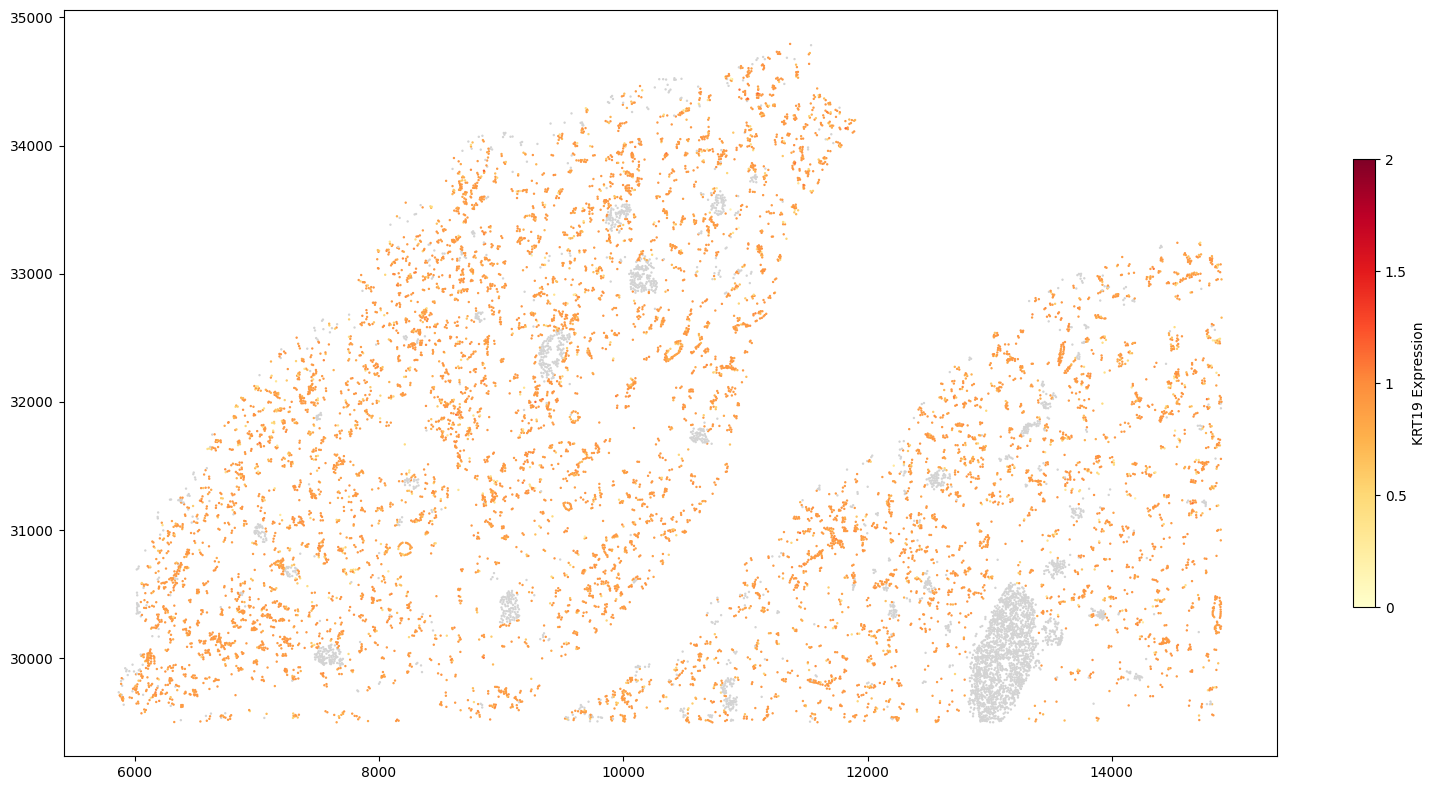

In [45]:
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']

def get_color(cell_type, expression):
    if cell_type != 'Ductal':
        return 'lightgrey'
    else:
        return plt.cm.YlOrRd(expression)
    
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'KRT19'].X.toarray().flatten()
#exps_above = exps[exps > 0.1]
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(min(exps), max(exps))
cmap = plt.cm.YlOrRd
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(exps[exps>0])  # Setting the array for ScalarMappable
cbar = plt.colorbar(sm, ax = ax, label='KRT19 Expression', shrink=0.6)
cbar.set_ticks([0, max(exps) / 4, 2 * max(exps) / 4,  3 * max(exps) / 4, 4 * max(exps) / 4])
cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Exocrine Cells')]
#ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_Ductal_KRT19.pdf', transparent=True, format = 'pdf')
plt.show()

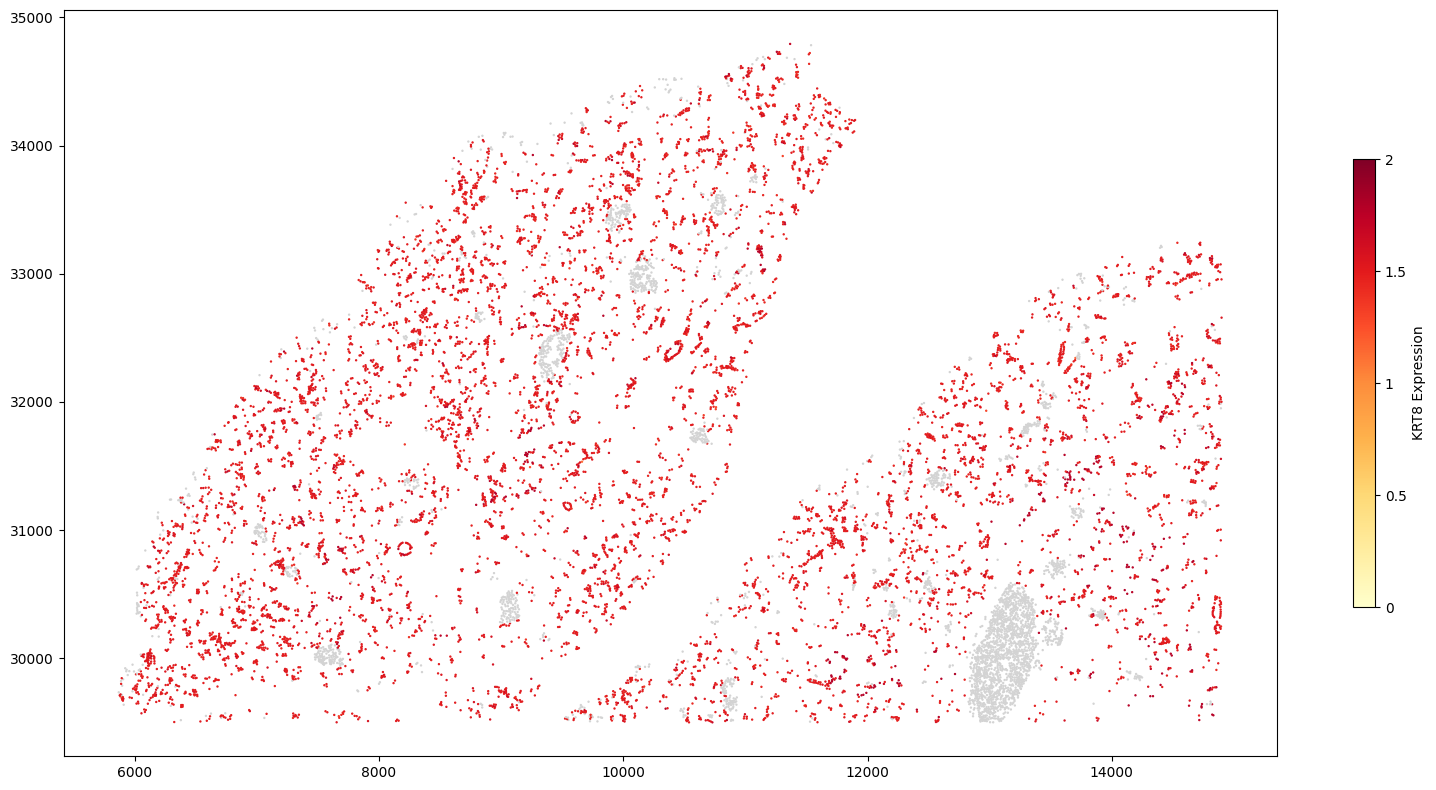

In [36]:
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']

def get_color(cell_type, expression):
    if cell_type != 'Ductal':
        return 'lightgrey'
    else:
        return plt.cm.YlOrRd(expression)
    
cts = d024_codex_imputed_rnaseq.obs['cell_type'].values
exps = d024_codex_imputed_rnaseq[:,'KRT8'].X.toarray().flatten()
#exps_above = exps[exps > 0.1]
colors = [get_color(cell_type, expression) for cell_type, expression in zip(cts, exps)]
fig, ax = plt.subplots(figsize=(16, 8))
scatter = plt.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c = colors, s = 0.5)
norm = Normalize(min(exps), max(exps))
cmap = plt.cm.YlOrRd
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(exps[exps>0])  # Setting the array for ScalarMappable
cbar = plt.colorbar(sm, ax = ax, label='KRT8 Expression', shrink=0.6)
cbar.set_ticks([0, max(exps) / 4, 2 * max(exps) / 4,  3 * max(exps) / 4, 4 * max(exps) / 4])
cbar.set_ticklabels(['0', '0.5', '1', '1.5', '2'])
legend_elements = [
    Patch(facecolor='grey', label='Non-Exocrine Cells')]
#ax.legend(handles=legend_elements, loc='upper right', title="Cell Types and Expression", bbox_to_anchor = (1 ,1))
plt.tight_layout()
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_spatial_Ductal_KRT8.pdf', transparent=True, format = 'pdf')
plt.show()

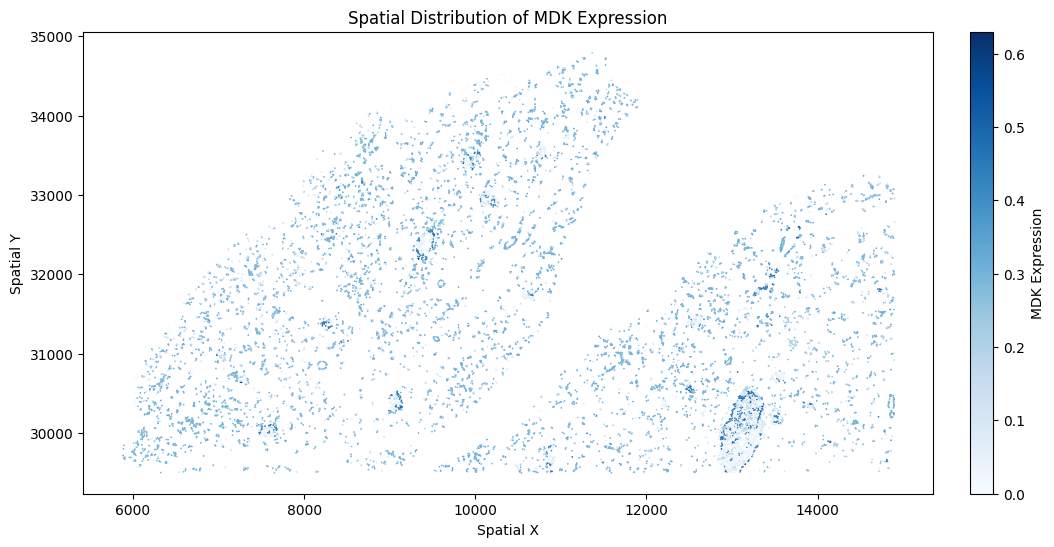

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your AnnData object 'adata' is already loaded
# Extract the spatial coordinates
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']

# Extract the expression data for the ligand (MDK) and receptor (ITGA6)
mdk_expression = d024_codex_imputed_rnaseq[:, 'MDK'].X.flatten()  # Assuming data is stored in a sparse matrix
itga6_expression = d024_codex_imputed_rnaseq[:, 'ITGA6'].X.flatten()

import matplotlib.colors as mcolors

# Define a color for values below 0.05 and the rest of the colors from 'Blues'
cmap = mcolors.LinearSegmentedColormap.from_list("custom_yellow_red", ["yellow", "red"], N=256)
norm = mcolors.Normalize(vmin=0, vmax=np.max(mdk_expression))



# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for MDK expression with adjusted color normalization
sc1 = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=mdk_expression,
                 cmap='Blues', s=0.5, alpha=1, linewidth=0.5)

# Add colorbar for MDK
cbar1 = plt.colorbar(sc1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('MDK Expression')

# Labeling and title
ax.set_title('Spatial Distribution of MDK Expression')
ax.set_xlabel('Spatial X')
ax.set_ylabel('Spatial Y')

# Remove grid lines
ax.grid(False)
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_MDK.pdf')
plt.show()




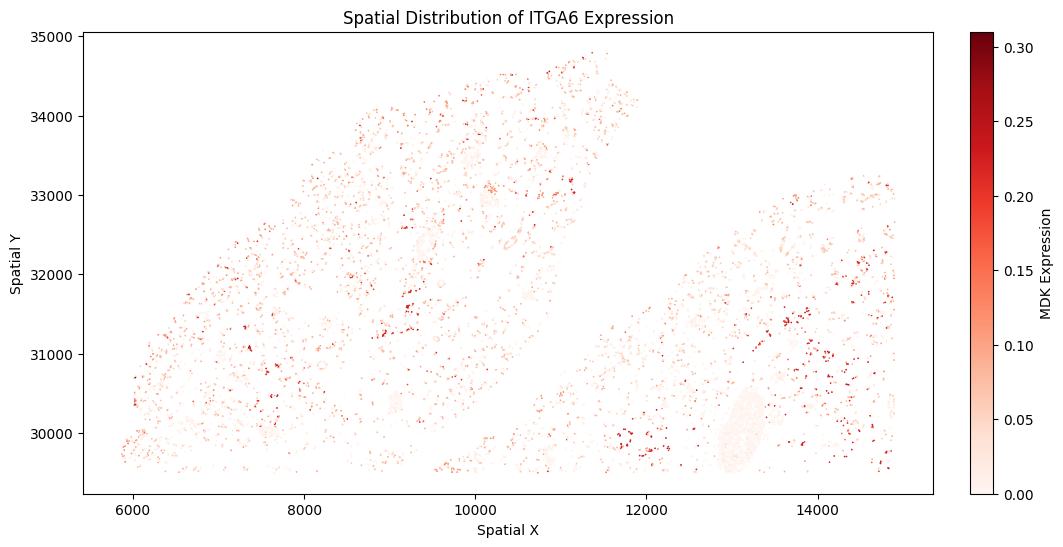

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your AnnData object 'adata' is already loaded
# Extract the spatial coordinates
spatial_coords = d024_codex_imputed_rnaseq.obsm['spatial']

# Extract the expression data for the ligand (MDK) and receptor (ITGA6)
itga6_expression = d024_codex_imputed_rnaseq[:, 'ITGA6'].X.flatten()

import matplotlib.colors as mcolors

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot for MDK expression with adjusted color normalization
sc1 = ax.scatter(spatial_coords[:, 0], spatial_coords[:, 1], c=itga6_expression,
                 cmap='Reds', s=0.5, alpha=1, linewidth=0.5)

# Add colorbar for MDK
cbar1 = plt.colorbar(sc1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('MDK Expression')

# Labeling and title
ax.set_title('Spatial Distribution of ITGA6 Expression')
ax.set_xlabel('Spatial X')
ax.set_ylabel('Spatial Y')

# Remove grid lines
ax.grid(False)
plt.savefig('/Users/luosanj/Desktop/figures/celLink/d024_ITGA6.pdf')

plt.show()




# RAG usage of GLKB

In [ ]:
import requests
url = "https://glkb.dcmb.med.umich.edu/api/search/rag"
data = {
    "query": "GCG ligand GIPR receptor sender alpha cells",
    "level": "sentence",
    "limit": 10
}

response = requests.post(url, json=data, verify=False)

#print(response.status_code)
response.json()